In [215]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import matplotlib.pyplot as plt


### 1. Find which pairs are cointegrated using 2 year data 2020-01-01 until 2022-12-31

Note : Cointegration no need test stationarity. If stationary series then theres no trend to speak of (i hope i understand this right)

In [216]:
start_date = "2015-01-01"
end_date = "2022-12-31"

In [217]:
# get close data
usd_jpy_data = yf.Ticker("USDJPY=X").history(start=start_date,end = end_date)['Close']
usd_cad_data = yf.Ticker("USDCAD=X").history(start=start_date,end = end_date)['Close']
usd_eur_data = yf.Ticker("USDEUR=X").history(start=start_date,end = end_date)['Close']
usd_gbp_data = yf.Ticker("USDGBP=X").history(start=start_date,end = end_date)['Close']
usd_chf_data = yf.Ticker("USDCHF=X").history(start=start_date,end = end_date)['Close']

# merge to one data frame
df_data = pd.DataFrame(zip(usd_jpy_data, usd_cad_data, usd_eur_data,usd_gbp_data,usd_chf_data),columns=['USDJPY','USDCAD','USDEUR','USDGBP','USDCHF'])
ccy_list = list(df_data.columns)


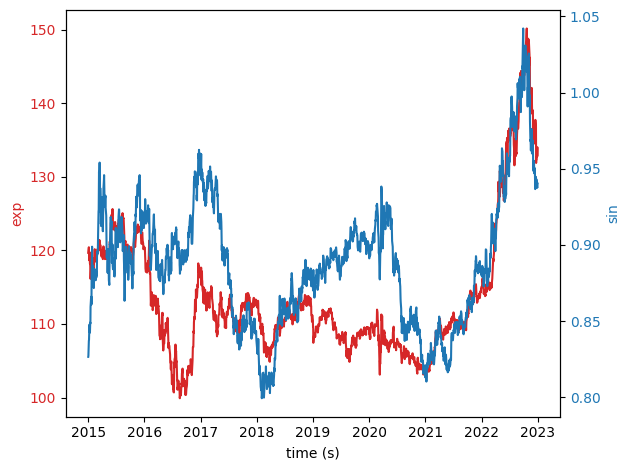

In [218]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(usd_jpy_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(usd_eur_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

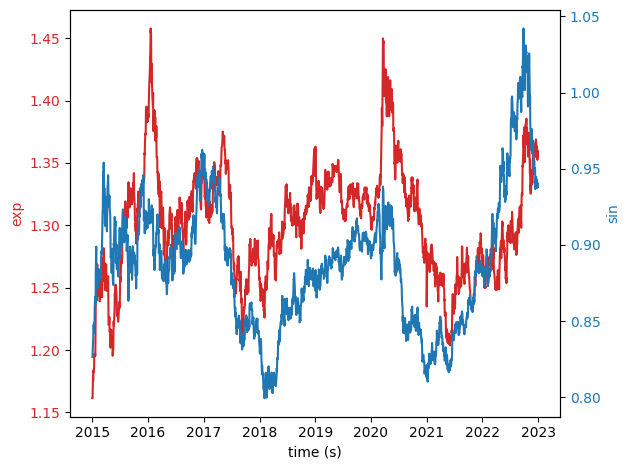

In [219]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(usd_cad_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(usd_eur_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

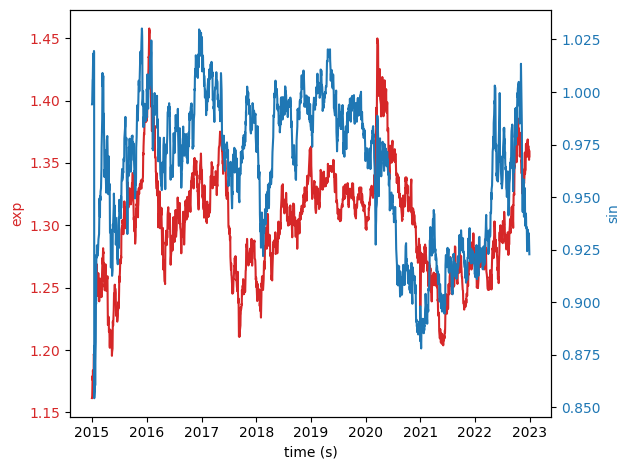

In [220]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(usd_cad_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(usd_chf_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [221]:
confidence_dict ={90:0, 95:1, 99:2}

In [222]:
# combination
basket_size = range(2, len(ccy_list)+1)
results_list = []

for the_size in basket_size:
    perm = combinations(ccy_list, the_size) 
    for i in perm:
        df_check_coint = df_data[list(i)]
        coint_test_result = coint_johansen(df_check_coint,  det_order=0, k_ar_diff=1)
        
        trace_statistic = coint_test_result.lr1
        maxeigen_statistic = coint_test_result.lr2
        trace_crit_val = coint_test_result.cvt
        maxeigen_crit_val = coint_test_result.cvm

        eigenvectors = coint_test_result.evec
        #print(f"checking pair {i}")
        #print(trace_statistic)
        #print(trace_crit_val)

        for x in confidence_dict.keys():
            confidence_level_col = confidence_dict[x]
            trace_crit_val_test = trace_crit_val[:,confidence_level_col]
            maxeigen_crit_val_test = maxeigen_crit_val[:,confidence_level_col]
            if np.all(trace_statistic >= trace_crit_val_test) and np.all(maxeigen_statistic >= maxeigen_crit_val_test):
                print(f"For convidence level {x}%, bucket {i} is cointegrated")
                print(f"eigen vectors {eigenvectors[:,0]}")
                print(f"hedge weights {eigenvectors[:,0]/abs(eigenvectors[:,0][0])}")
                results_list.append({'bucketname':i, 'eigenvectors':eigenvectors[:,0], 'weights':eigenvectors[:,0]/abs(eigenvectors[:,0][0])})




For convidence level 90%, bucket ('USDCAD', 'USDEUR') is cointegrated
eigen vectors [24.70337217 -7.26022083]
hedge weights [ 1.         -0.29389594]
For convidence level 95%, bucket ('USDCAD', 'USDEUR') is cointegrated
eigen vectors [24.70337217 -7.26022083]
hedge weights [ 1.         -0.29389594]
For convidence level 99%, bucket ('USDCAD', 'USDEUR') is cointegrated
eigen vectors [24.70337217 -7.26022083]
hedge weights [ 1.         -0.29389594]
For convidence level 90%, bucket ('USDCAD', 'USDGBP') is cointegrated
eigen vectors [22.68693815 -0.76348665]
hedge weights [ 1.         -0.03365314]
For convidence level 95%, bucket ('USDCAD', 'USDGBP') is cointegrated
eigen vectors [22.68693815 -0.76348665]
hedge weights [ 1.         -0.03365314]
For convidence level 90%, bucket ('USDCAD', 'USDCHF') is cointegrated
eigen vectors [ 21.42565386 -30.61340293]
hedge weights [ 1.         -1.42882001]
For convidence level 95%, bucket ('USDCAD', 'USDCHF') is cointegrated
eigen vectors [ 21.42565386 

### 2. Test Spread

In [223]:
results_list

[{'bucketname': ('USDCAD', 'USDEUR'),
  'eigenvectors': array([24.70337217, -7.26022083]),
  'weights': array([ 1.        , -0.29389594])},
 {'bucketname': ('USDCAD', 'USDEUR'),
  'eigenvectors': array([24.70337217, -7.26022083]),
  'weights': array([ 1.        , -0.29389594])},
 {'bucketname': ('USDCAD', 'USDEUR'),
  'eigenvectors': array([24.70337217, -7.26022083]),
  'weights': array([ 1.        , -0.29389594])},
 {'bucketname': ('USDCAD', 'USDGBP'),
  'eigenvectors': array([22.68693815, -0.76348665]),
  'weights': array([ 1.        , -0.03365314])},
 {'bucketname': ('USDCAD', 'USDGBP'),
  'eigenvectors': array([22.68693815, -0.76348665]),
  'weights': array([ 1.        , -0.03365314])},
 {'bucketname': ('USDCAD', 'USDCHF'),
  'eigenvectors': array([ 21.42565386, -30.61340293]),
  'weights': array([ 1.        , -1.42882001])},
 {'bucketname': ('USDCAD', 'USDCHF'),
  'eigenvectors': array([ 21.42565386, -30.61340293]),
  'weights': array([ 1.        , -1.42882001])},
 {'bucketname': 

In [224]:
# trial 1
spread =usd_cad_data*results_list[0]['weights'][0] - usd_eur_data*results_list[0]['weights'][1]
adftest = adfuller(spread)


In [225]:
print(f"adf statistic : {adftest[0]}, p value : {adftest[1]}")

adf statistic : -3.6990987546945426, p value : 0.004125848834103542


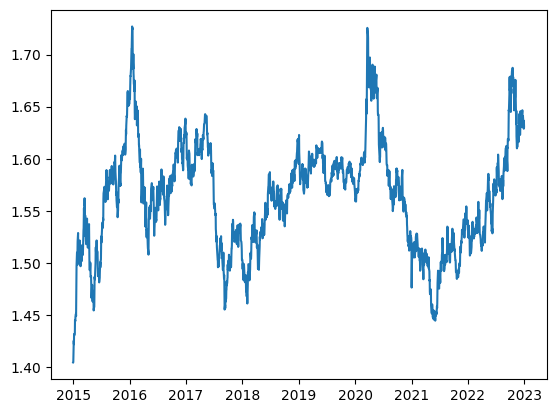

In [226]:
plt.plot(spread)

### 3. Apply some mean reversion signal generation to the spread